## 1. Import Required Libraries

In [1]:
import pandas as pd
from typing import List, Dict
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 42
RATING_GROUPS = {
    "negative": [1,2],
    "positive": [4,5],
}

## 2. Load and Sample the Large Dataset

#### The original dataset contains ~17 million movie reviews. We sample a manageable subset for analysis while maintaining data quality.

### 2.1. Sampling Function
#### Function to read large JSONL file in chunks and sample data efficiently.

In [3]:
def sample_large_jsonl(
    input_file: str,
    output_file: str,
    target_size: int,
    chunksize: int = 100_000,
    sample_frac_per_chunk: float = 0.10,
    rating_col: str = "rating",
    valid_ratings: List[int] = [1, 2, 3, 4, 5],
):
    """
    Sampling of large chunk of json data
    """
    collected = []
    current_size = 0

    reader = pd.read_json(
        input_file,
        lines=True,
        chunksize=chunksize,
    )

    for chunk in reader:
        # Filter valid ratings
        chunk = chunk[chunk[rating_col].isin(valid_ratings)]

        # Sample from chunk
        sampled = chunk.sample(
            frac=sample_frac_per_chunk,
            random_state=RANDOM_STATE,
        )

        collected.append(sampled)
        current_size += len(sampled)

        if current_size >= target_size:
            break

    df = pd.concat(collected, ignore_index=True)

    # Final sampling
    df = df.sample(n=target_size, random_state=RANDOM_STATE)

    df.to_csv(output_file, index=False)

    return df

### 2.2. Execute Sampling

#### Sampling 500,000 reviews from the original dataset.

In [4]:
df_sampled = sample_large_jsonl(
    input_file="Movies_and_TV.jsonl",
    output_file="Sampled_500K_Reviews.csv",
    target_size=500_000,
)

In [5]:
df = pd.read_csv("Sampled_500K_Reviews.csv")

## 3. Exploratory Data Analysis (EDA)

#### Exploring the sampled dataset to understand its structure and characteristics.

### 3.1. Dataset Overview

In [6]:
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Good show annoying volumes,This is a fun avengers cartoon for the whole f...,[],B004MYYHGI,B004MYYHGI,AG22KULVEHUKK73GXUAVAR655PDA,2017-05-09 17:59:05.000,2,True
1,5,A very good show in the cops and robbers genre,Great to see series which spend time on charac...,[],B00I3MQNWG,B00I3MQNWG,AHQ5RRS25O6CUF25DWOGNI6ZBFZQ,2015-02-28 21:47:40.000,0,True
2,5,Excellent in all categories,I borrowed a copy of this from a friend and pr...,[],B000VECADK,B000VECADK,AFEPDF66XU7DGLXL2YRRGABEGC2Q,2012-01-14 18:23:05.000,0,True
3,2,Two Stars,Not sure about this one yet,[],B01M07BNL3,B01M07BNL3,AHYRD5UVXUWNTYSIUMS5O34734VA,2017-01-28 08:04:16.000,0,True
4,4,Enjoyed it,A fun watch,[],B01CH2GQYM,B01CH2GQYM,AHXWQ6EQVGNPKDQ2K4LJHNF3P6RQ,2017-01-12 02:21:12.000,0,True


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   rating             500000 non-null  int64 
 1   title              499931 non-null  object
 2   text               499911 non-null  object
 3   images             500000 non-null  object
 4   asin               500000 non-null  object
 5   parent_asin        500000 non-null  object
 6   user_id            500000 non-null  object
 7   timestamp          500000 non-null  object
 8   helpful_vote       500000 non-null  int64 
 9   verified_purchase  500000 non-null  bool  
dtypes: bool(1), int64(2), object(7)
memory usage: 34.8+ MB


### 3.2. Rating Distribution

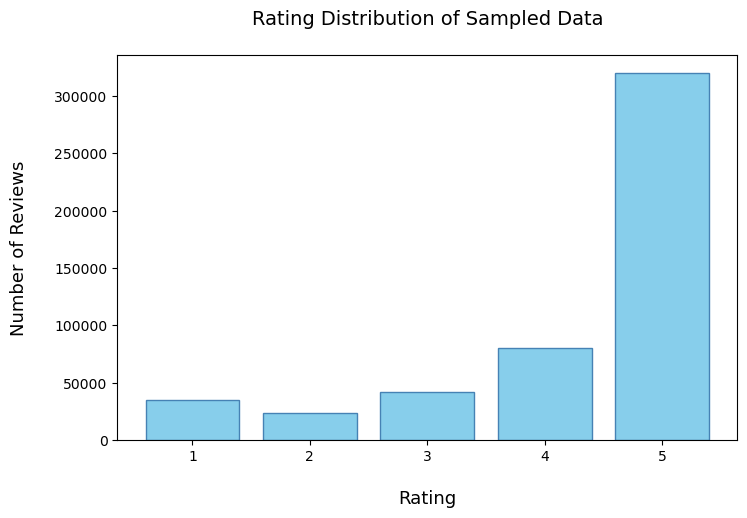

In [8]:
rating_counts = df["rating"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='steelblue')
plt.title('Rating Distribution of Sampled Data\n', fontsize=14)
plt.xlabel('\nRating', fontsize=13)
plt.ylabel('Number of Reviews\n', fontsize=13)
plt.savefig("rating_distribution_of_sampled_data.png", dpi=300, bbox_inches='tight')
plt.show()

### 3.3. Sentiment Distribution (Positive vs Negative)

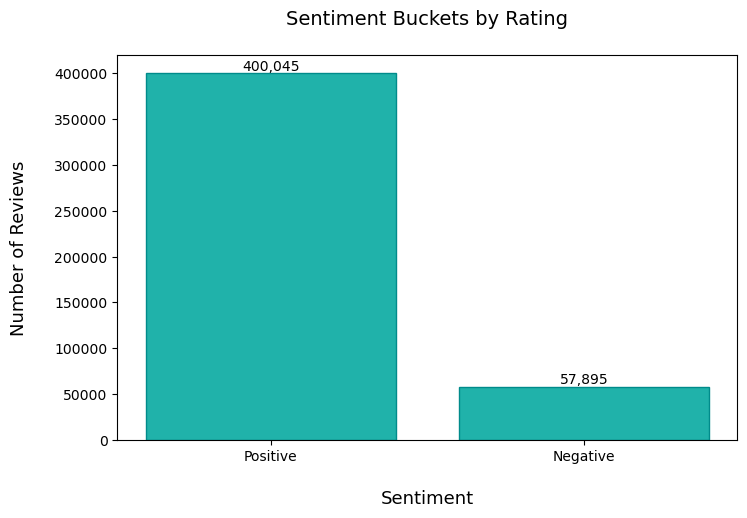

In [9]:
positive_count = df[df["rating"].isin([4, 5])].shape[0]
negative_count = df[df["rating"].isin([1, 2])].shape[0]

sentiment_counts = {
    "Positive": positive_count,
    "Negative": negative_count,
}

index = list(sentiment_counts.keys())
values = list(sentiment_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(index, values, color='lightseagreen', edgecolor='darkcyan',)
plt.title("Sentiment Buckets by Rating\n", fontsize=14)
plt.xlabel("\nSentiment", fontsize=13)
plt.ylabel("Number of Reviews\n", fontsize=13)
for i, value in enumerate(values):
    plt.text(i, value,f"{value:,}",ha="center",va="bottom",fontsize=10)

plt.savefig("sentiment_buckets_sampled_data", dpi=300, bbox_inches='tight')
plt.show()

### 3.4. Duplicate Review Check

In [10]:
duplicate_reviews = df.duplicated(subset=["text"]).sum()
duplicate_title_text = df.duplicated(subset=["title", "text"]).sum()

print("\nDuplicate analysis:")
print(f"Duplicate review texts: {duplicate_reviews}")
print(f"Duplicate text percentage: {duplicate_reviews / len(df):.2%}")

print(f"Duplicate Title & Text pairs: {duplicate_title_text}")
print(f"Title & Text duplicate percentage: {duplicate_title_text / len(df):.2%}")


Duplicate analysis:
Duplicate review texts: 69097
Duplicate text percentage: 13.82%
Duplicate Title & Text pairs: 49203
Title & Text duplicate percentage: 9.84%


### 3.5. Missing Value Check

In [11]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
rating                0
title                69
text                 89
images                0
asin                  0
parent_asin           0
user_id               0
timestamp             0
helpful_vote          0
verified_purchase     0
dtype: int64


### 3.6. Review Text Length Distribution

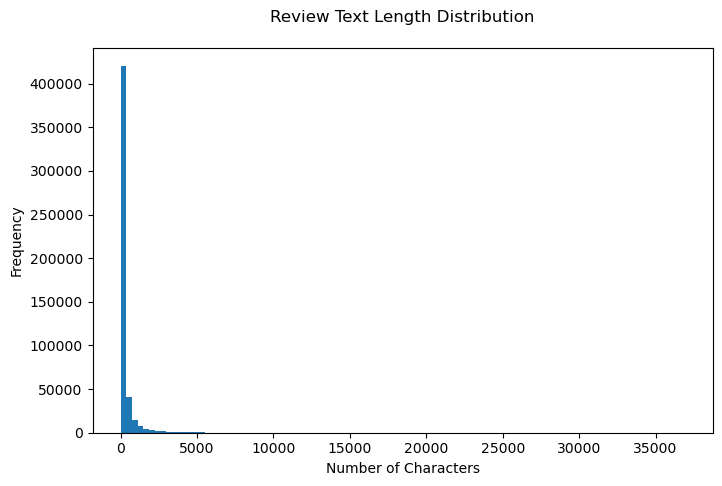

In [12]:
text_length = df["text"].str.len()

plt.figure(figsize=(8, 5))
plt.hist(text_length.values, bins=100)
plt.title("Review Text Length Distribution\n")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.savefig("review_text_distribution_sampled_date", dpi=300, bbox_inches='tight')
plt.show()

### 3.7. Verified Purchase Overview

In [13]:
df["verified_purchase"].value_counts()

verified_purchase
True     403690
False     96310
Name: count, dtype: int64

## 4. Data Cleaning

### 4.1. Remove Neutral Ratings (Keep only 1, 2, 4, 5)

In [14]:
df = df[df["rating"].isin([1, 2, 4, 5])]
print("After keeping positive & negative ratings:", df.shape)

After keeping positive & negative ratings: (457940, 10)


### 4.2. Remove Duplicate Reviews

In [15]:
before = len(df)

df = df.drop_duplicates(subset=["text"])

after = len(df)

print(f"Removed {before - after} duplicate reviews")
print("After deduplication:", df.shape)

Removed 65181 duplicate reviews
After deduplication: (392759, 10)


### 4.3. Review Count After Cleaning

In [16]:
# Reviews Count 
positive_count = df[df["rating"].isin([4, 5])].shape[0]
negative_count = df[df["rating"].isin([1, 2])].shape[0]

print("Positive reviews after cleaning:", positive_count)
print("Negative reviews after cleaning:", negative_count)

Positive reviews after cleaning: 337491
Negative reviews after cleaning: 55268


## 5. Data Balancing

### 5.1. Determine Sample Size Per Class

In [17]:
# Finding the minimum data available
min_available = min(positive_count, negative_count)
TARGET_PER_CLASS = min(30_000, min_available)

print(f"Final samples per review category: {TARGET_PER_CLASS}")

Final samples per review category: 30000


### 5.2. Sample Equal Reviews Per Sentiment

In [18]:
# Finalized Positive and Negaative Review Dataset
df_positive = df[df["rating"].isin([4, 5])].sample(n=TARGET_PER_CLASS, random_state=RANDOM_STATE)
df_negative = df[df["rating"].isin([1, 2])].sample(n=TARGET_PER_CLASS, random_state=RANDOM_STATE)

### 5.3. Combine and Shuffle Dataset

In [19]:
df_final = pd.concat([df_positive, df_negative])
df_final = df_final.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [20]:
df_final.shape

(60000, 10)

### 5.4. Export Final Dataset
#### Exporting the balanced dataset (60,000 reviews: 30,000 positive + 30,000 negative) for model training.

In [21]:
df_final.to_csv("Final_Reviews.csv", index=False)